In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
# Binarization transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.44MB/s]


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        return self.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [4]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    KLD = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return BCE + KLD


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [6]:
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_dataset):.4f}")


Epoch [1/20], Loss: 157.4999
Epoch [2/20], Loss: 108.7556
Epoch [3/20], Loss: 99.7633
Epoch [4/20], Loss: 95.7398
Epoch [5/20], Loss: 93.2672
Epoch [6/20], Loss: 91.5062
Epoch [7/20], Loss: 90.2288
Epoch [8/20], Loss: 89.2631
Epoch [9/20], Loss: 88.5212
Epoch [10/20], Loss: 87.8002
Epoch [11/20], Loss: 87.2033
Epoch [12/20], Loss: 86.7453
Epoch [13/20], Loss: 86.3375
Epoch [14/20], Loss: 85.9341
Epoch [15/20], Loss: 85.6518
Epoch [16/20], Loss: 85.3283
Epoch [17/20], Loss: 85.0178
Epoch [18/20], Loss: 84.8112
Epoch [19/20], Loss: 84.5961
Epoch [20/20], Loss: 84.3625


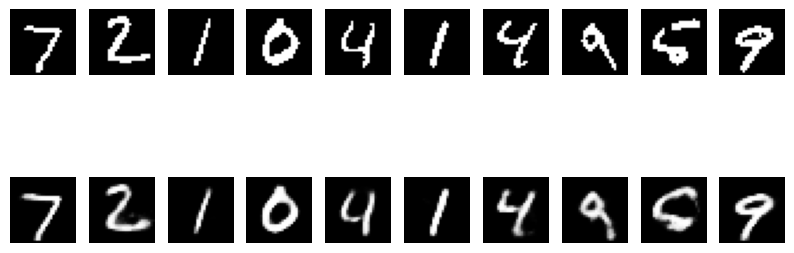

In [7]:
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.view(-1, 784).to(device)
    recon, _, _ = model(data)

plt.figure(figsize=(10, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
    plt.axis('off')

    # Reconstruction
    plt.subplot(2, 10, i + 11)
    plt.imshow(recon[i].cpu().view(28, 28), cmap='gray')
    plt.axis('off')

plt.show()

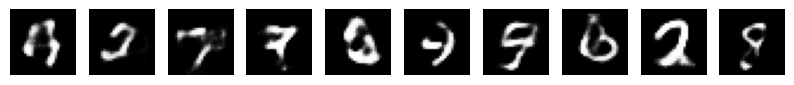

In [8]:
with torch.no_grad():
    z = torch.randn(10, 20).to(device)
    samples = model.decode(z)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(samples[i].cpu().view(28, 28), cmap='gray')
    plt.axis('off')

plt.show()
